In [16]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from visualization import contour_generator
from tqdm import tqdm
import matplotlib as mpl
mpl.style.use('pof')

In [11]:
from scipy.interpolate import griddata
import gc
class Interface():
    '''
    Class for every interface related output. Unstructured grid.   
    '''  
    def __init__(self, L0, N, path, t, PRUNING=True):
        '''
        Input:
            L0, N: The desired output grid number
            working_dir: The case's directory
            t: Time of this eta file.
            PRUNING: If eta is output by multiple processes and have multiple headers
                    (might become obsolete).    
        Output:
            self.eta_tile: 2D interpolated eta
            self.p: 2D interpolated surface pressure
            self.tau: 2D interpolated surface viscous stress
        '''
        self.L0 = L0; self.N = N; self.t = t
        xarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 #Centered grid
        zarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 #size of self.N*self.N
        x_tile, z_tile = np.meshgrid(xarray,zarray)
        filename = path + 'eta/eta_loc_t%g' %self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        if PRUNING:
            snapshot = snapshot[snapshot.x != 'x']
            snapshot = snapshot.astype('float')
            snapshot = snapshot[snapshot.pos < 1 + 0.4/4] # Exclude data over slope 0.4
        # Interpolate over x-z plane
        xdata = np.array(snapshot.x, dtype=float); zdata = np.array(snapshot.z, dtype=float) 
        etadata = np.array(snapshot.pos, dtype=float); pdata = np.array(snapshot.p, dtype=float)
        graddata = np.array(snapshot.epsilon, dtype=float)
        dudydata = np.array(snapshot.dudy1, dtype=float)
        dvdxdata = np.array(snapshot.dvdx1, dtype=float)
        dudxdata = np.array(snapshot.dudx1, dtype=float)
        dvdydata = np.array(snapshot.dvdy1, dtype=float)
        del (snapshot); gc.collect()        
        self.eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='nearest')
        self.p_tile = griddata((xdata.ravel(), zdata.ravel()), pdata.ravel(), (x_tile, z_tile), method='nearest')
        self.dudy_tile = griddata((xdata.ravel(), zdata.ravel()), dudydata.ravel(), (x_tile, z_tile), method='nearest')
        self.dvdx_tile = griddata((xdata.ravel(), zdata.ravel()), dvdxdata.ravel(), (x_tile, z_tile), method='nearest')
        self.dudx_tile = griddata((xdata.ravel(), zdata.ravel()), dudxdata.ravel(), (x_tile, z_tile), method='nearest')
        self.dvdy_tile = griddata((xdata.ravel(), zdata.ravel()), dvdydata.ravel(), (x_tile, z_tile), method='nearest')
        self.grad_tile = griddata((xdata.ravel(), zdata.ravel()), graddata.ravel(), (x_tile, z_tile), method='nearest')
#         self.taudata = taudata; self.xdata = xdata; self.zdata = zdata; self.pdata = pdata

In [83]:
interface = Interface(L0 = 2*np.pi, N = 512, path = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/',
                      t = 85, PRUNING=True)

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(interface.xdata, interface.zdata, interface.pdata-np.average(interface.pdata), c=interface.pdata, cmap='Greens')

Text(0.5, 1.0, '$t=84, \\tau_f = 0.427\\tau, \\tau_{\\nu} = 0.550\\tau$')

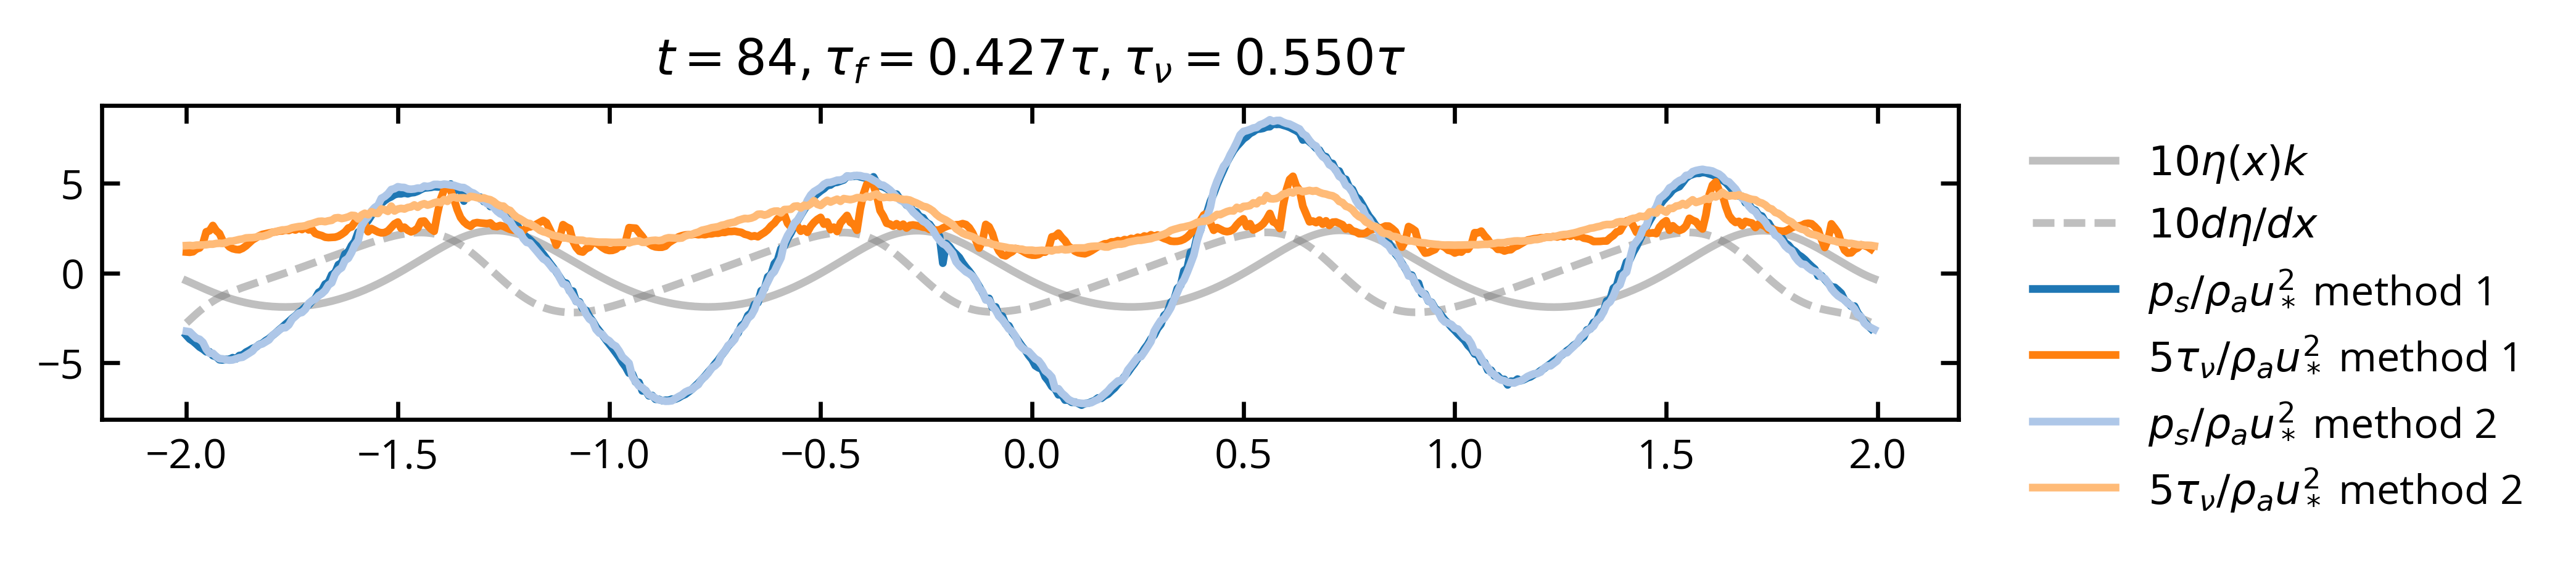

In [82]:
'''
    Comparison of 1D averaged stress between two methods.
'''
plt.figure(figsize=[7,1.5])

L0 = 2*np.pi; N =512
xarray = np.linspace(-L0/2.,L0/2.,N,endpoint=False)+L0/2**N/2
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, alpha = 0.5, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', alpha = 0.5, label=r'$10d\eta/dx$', color = 'gray')

# Method 1 bulk interpolation
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[3][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
         label = r'$p_s/\rho_{a}u_*^2$ method 1', color = plt.cm.tab20(0))
plt.plot(xarray[0:-1]/(2*np.pi/4), 5.*(tauv_dudy[1][0:-1])*nu_a/0.25**2, 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$ method 1', color = plt.cm.tab20(2))

# Method 2 probing interface
p1d = np.average((interface.p_tile-np.average(interface.p_tile))/0.25**2/rho_a, axis = 0)
tau1d = np.average(interface.dudy_tile*nu_a/0.25**2, axis = 0)
tau1d_extra = np.average((interface.dvdx_tile+interface.dudy_tile)*nu_a/0.25**2, axis = 0)
# tau1d = np.average(interface.tau_tile/0.25**2/rho_a, axis = 0)
plt.plot(xarray/(2*np.pi/4), p1d, label=r'$p_s/\rho_{a}u_*^2$ method 2', color = plt.cm.tab20(1)) 
plt.plot(xarray/(2*np.pi/4), 5.*tau1d, label=r'$5\tau_{\nu}/\rho_{a}u_*^2$ method 2', color = plt.cm.tab20(3))
# plt.plot(xarray/(2*np.pi/4), 5.*tau1d_extra, '--', label=r'$5\tau_{\nu}/\rho_{a}u_*^2$ method 2', color = plt.cm.tab20(3))

# plt.ylim([-14,14])
# plt.xlim([-2.3,2.3])
formdrag = np.sum(p1d*eta_1D_grad_filtered)/512
shearstress = np.sum(tau1d)/512
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title(r"$t=%g, \tau_f = %.3f\tau, \tau_{\nu} = %.3f\tau$" %(t, formdrag, shearstress))

In [73]:
print(np.sum(p1d*eta_1D_grad_filtered)/512)
print(np.sum(tau1d)/512)
print(np.sum(tau1d/(1+eta_1D_grad_filtered**2)**0.5)/512)

0.35447135412111264
0.5383250039031262
0.5319353307806725


In [106]:
p1d = (pinterp[3][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2)
tau1d = tauv_dudy[1]*nu_a/0.25**2
print(np.sum(p1d*eta_1D_grad_filtered[0:-1])/512)
print(np.sum(tau1d)/512)

0.47501048187998995
0.5219005011710582


(-3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793)

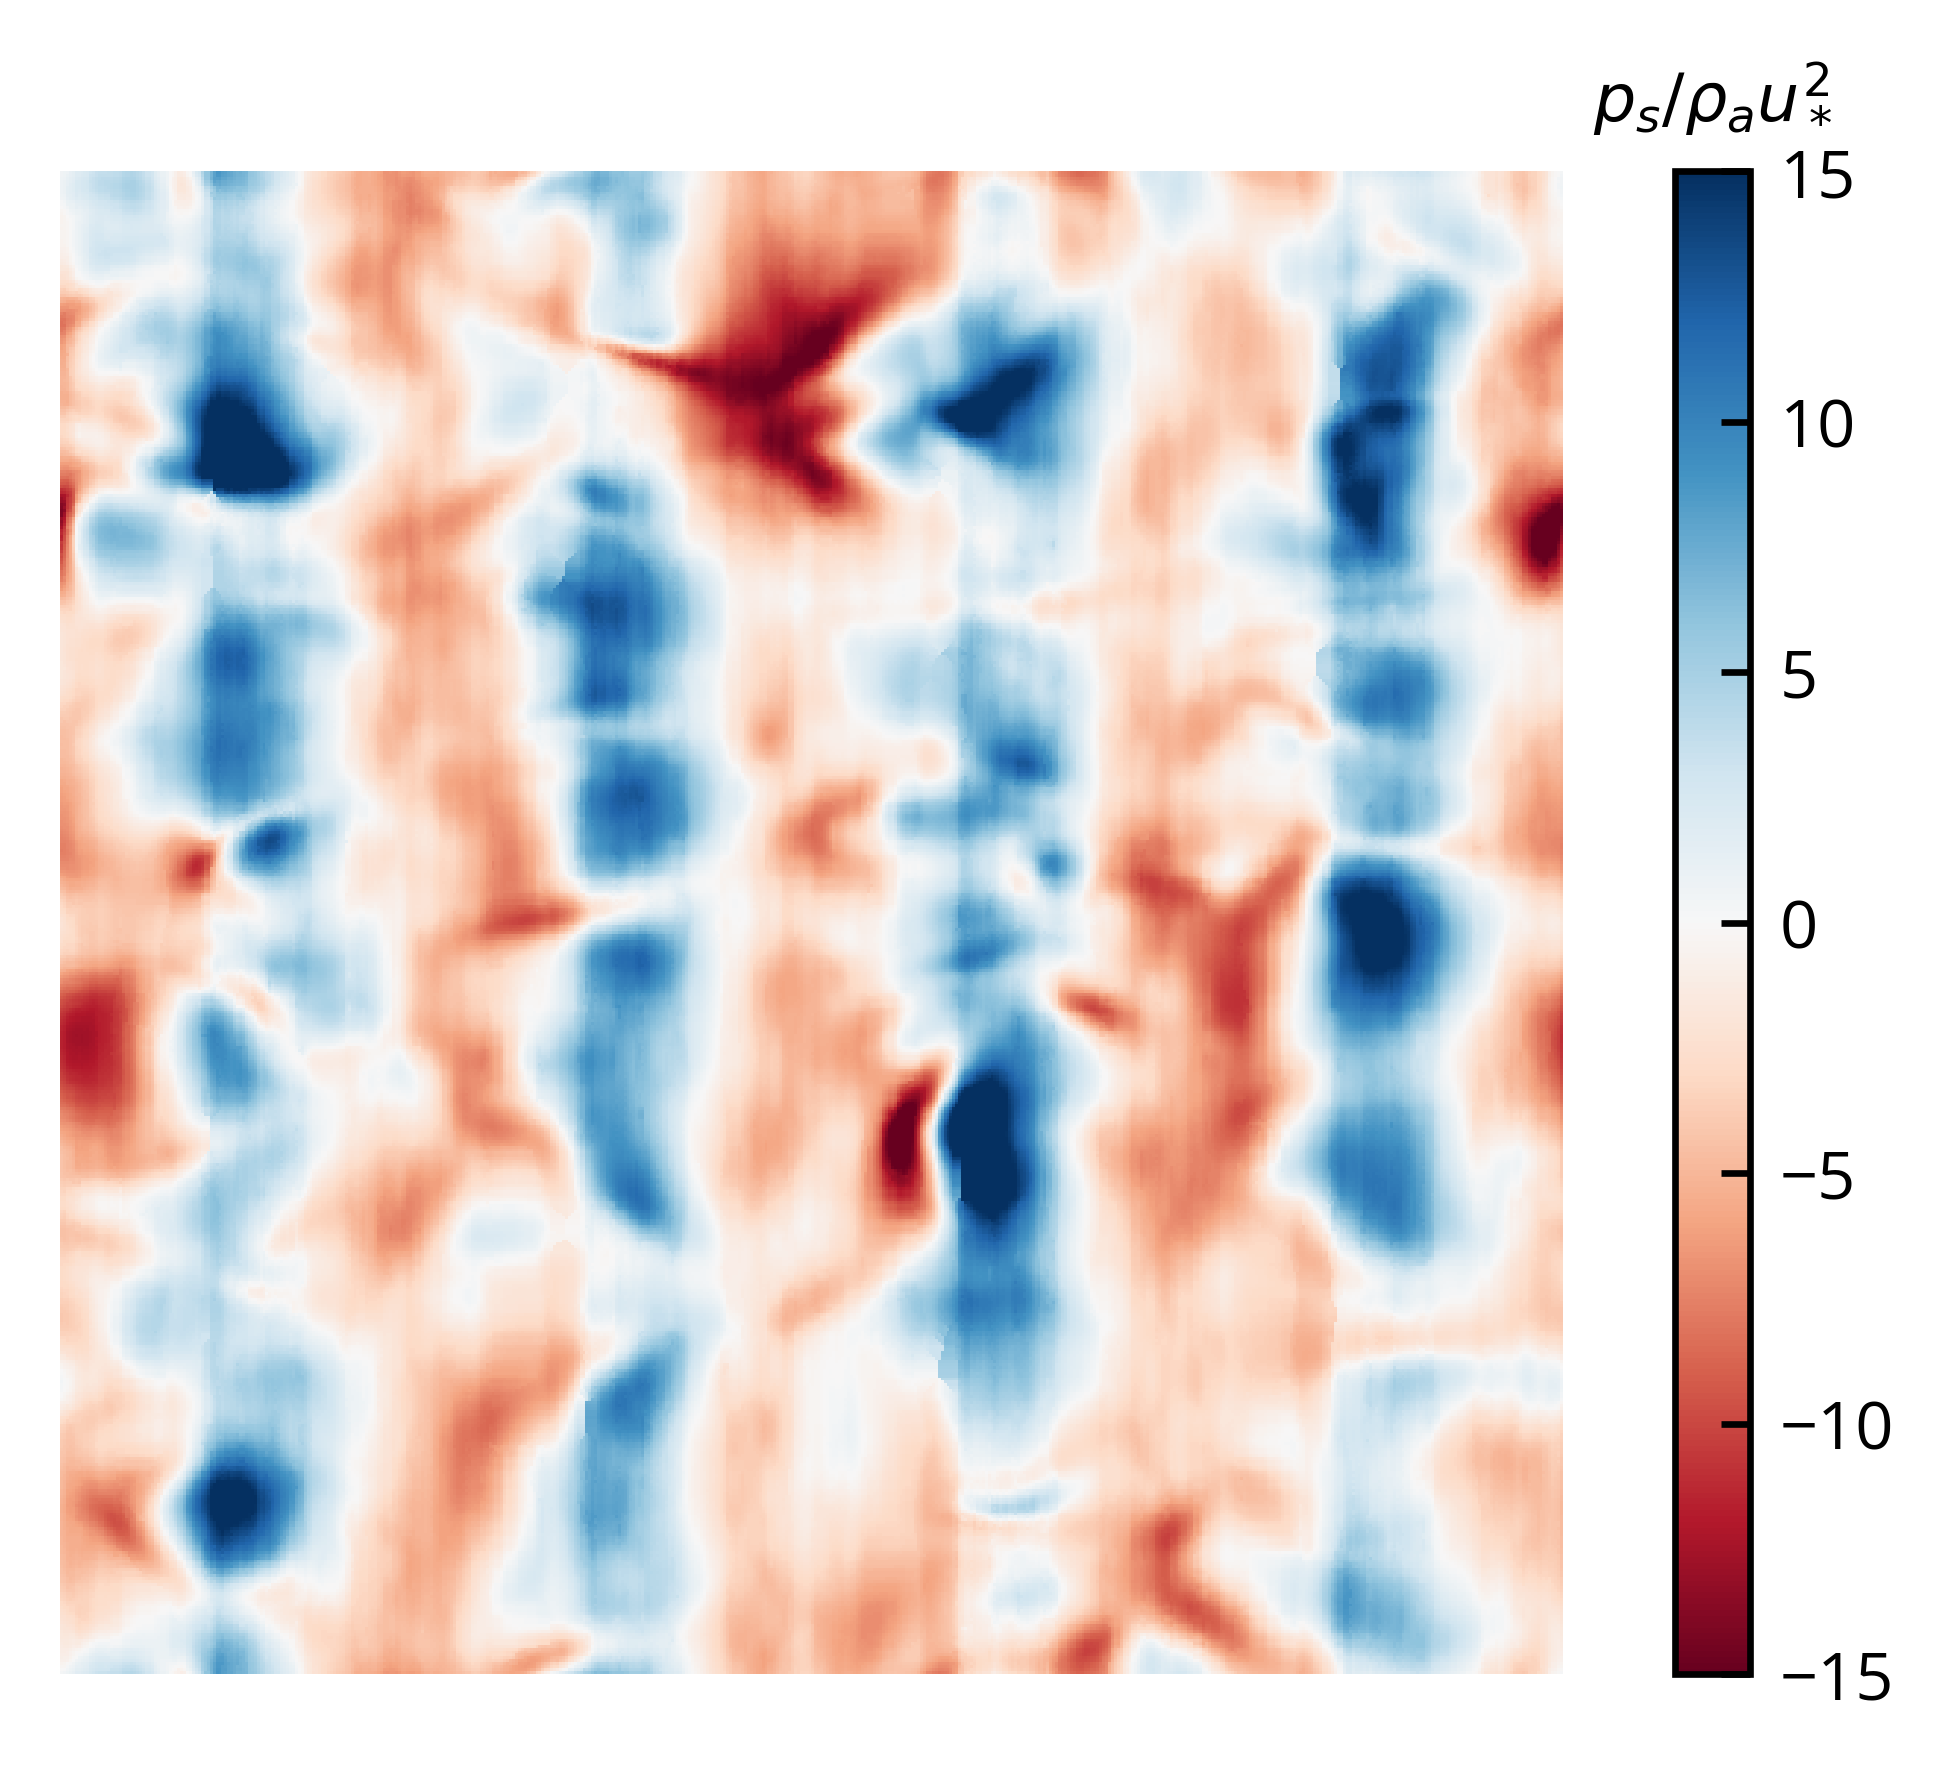

In [63]:
plt.figure(figsize=[4,3])

NGRID = 512
rho_a = 0.001225
nu_a = 0.25*(2*np.pi-1)/720
NSLICE = 256
L0 = 2*np.pi

plt.imshow((interface.p_tile-np.average(interface.p_tile))/0.25**2/rho_a, cmap='RdBu', 
           vmax = 15, vmin = -15, extent = [-L0/2,L0/2,-L0/2,L0/2])
ax = plt.gca()
ax.text(1.1,1.05, r'$p_s/\rho_{a}u_*^2$', ha='center', va='center', transform=ax.transAxes)
cbar = plt.colorbar(); plt.axis('off')

(-3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793)

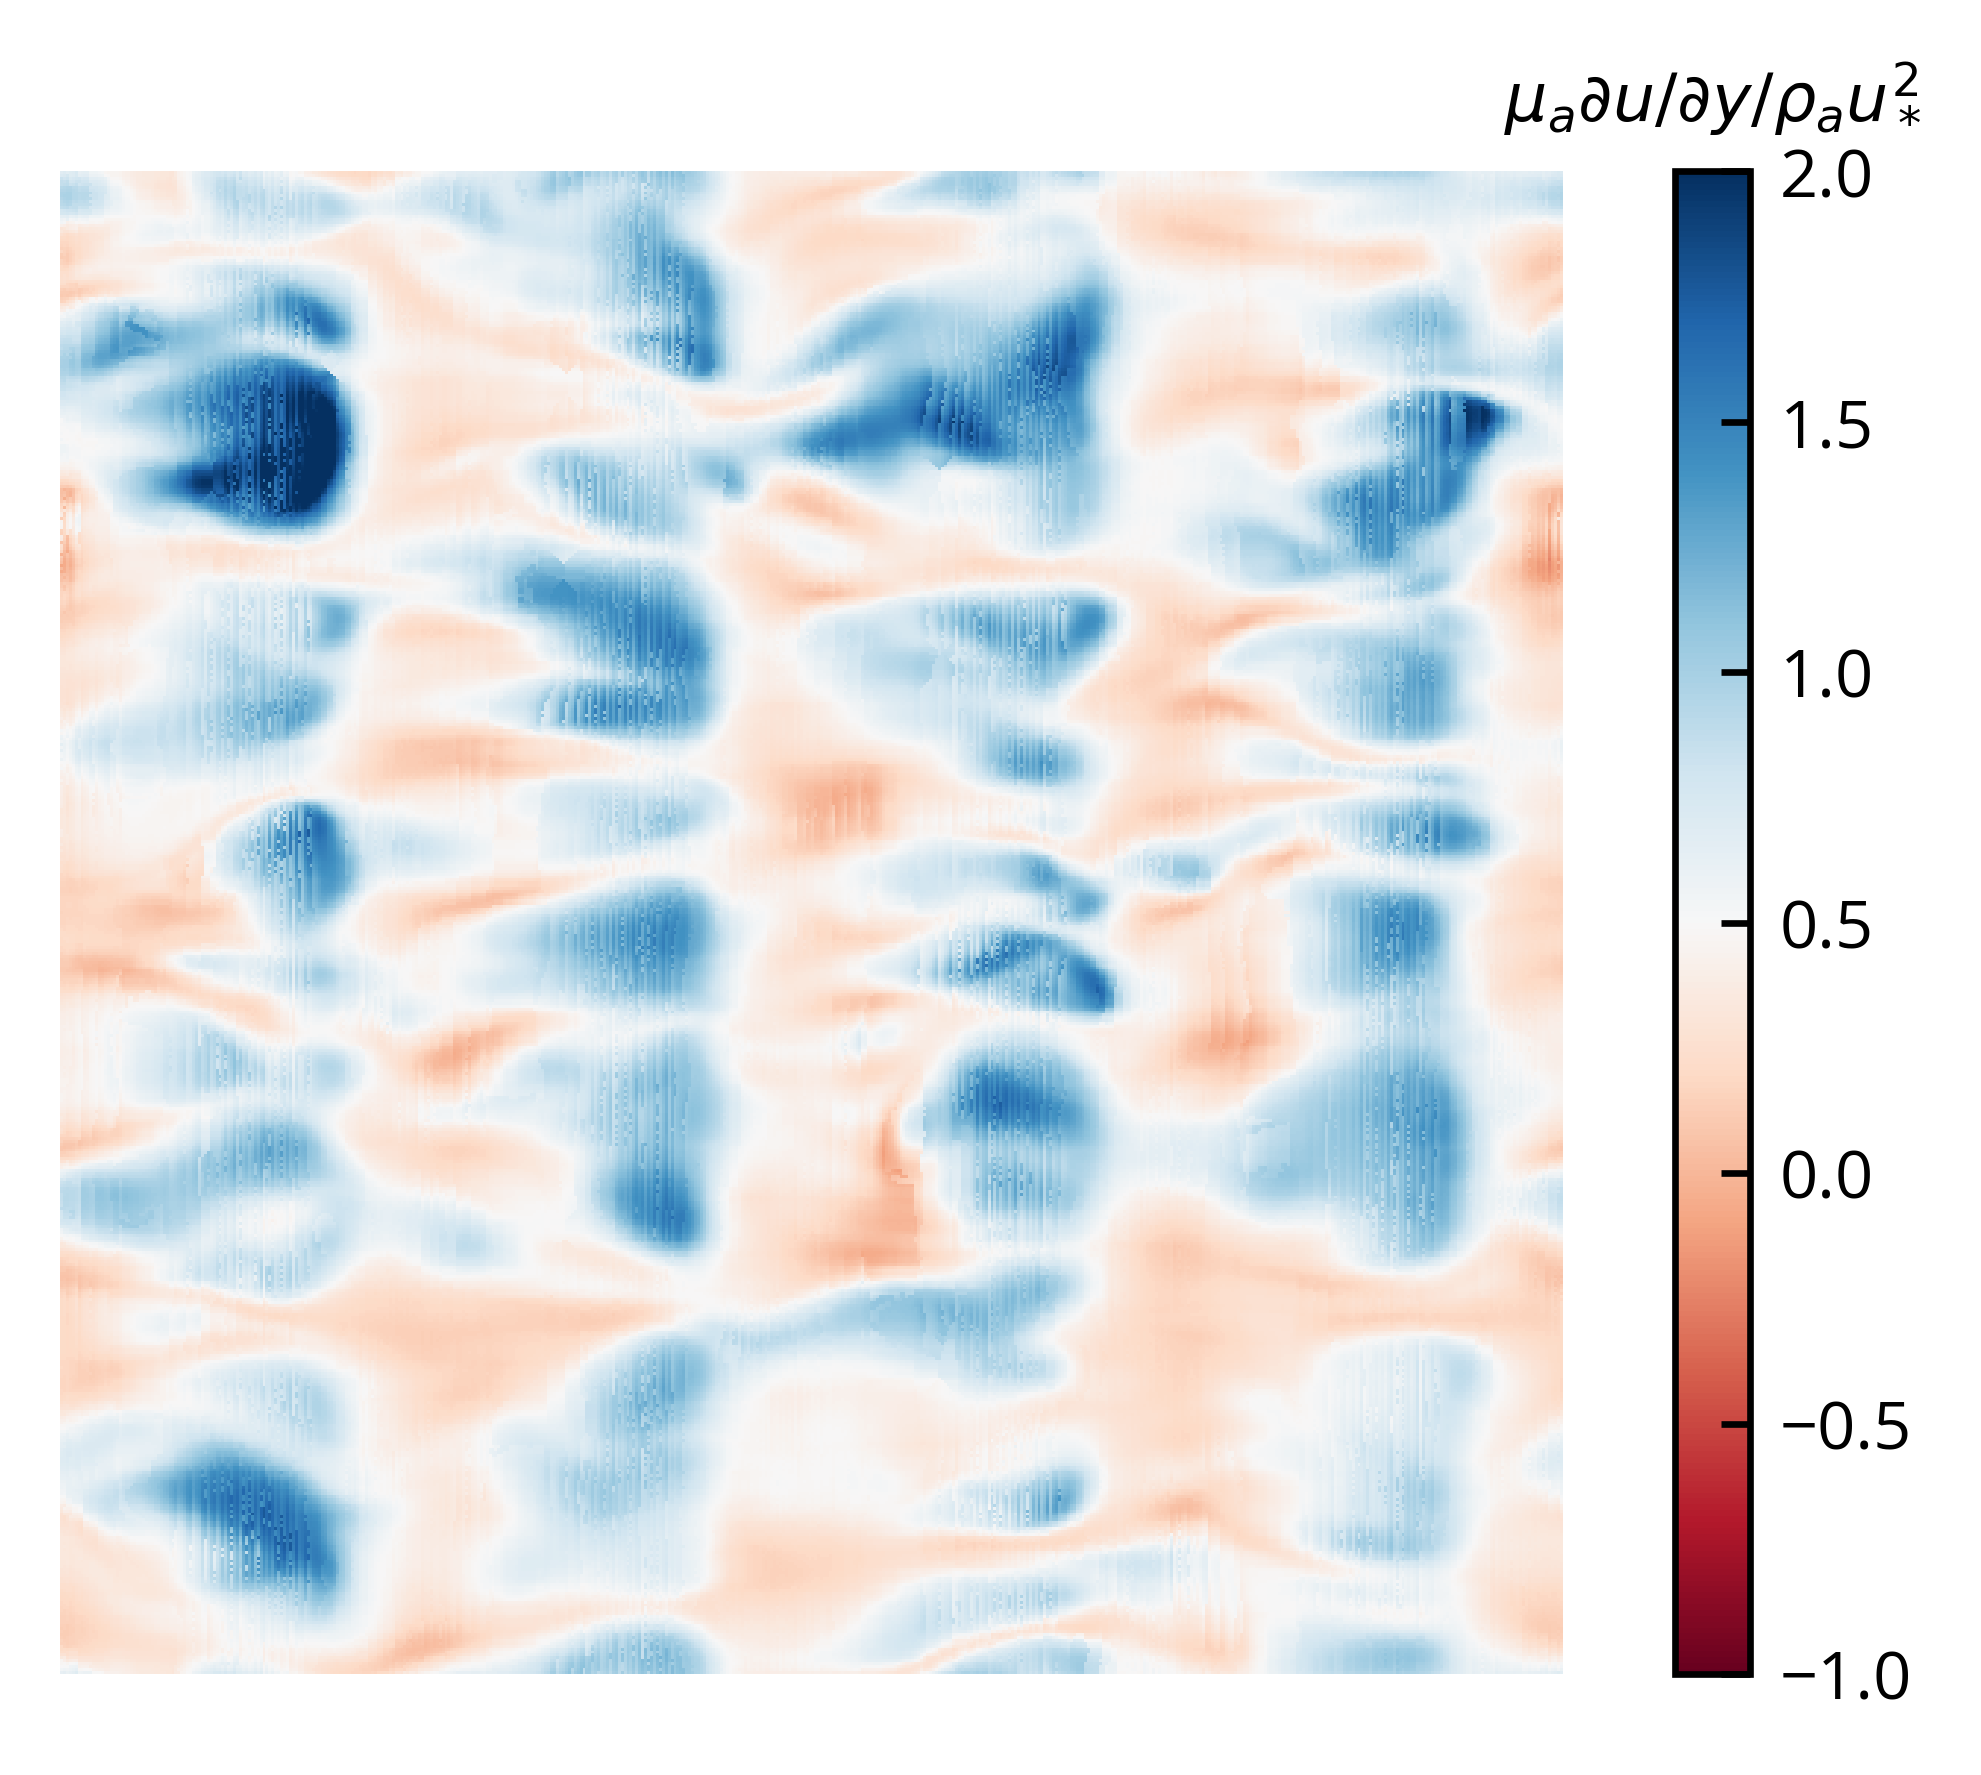

In [62]:
plt.figure(figsize=[4,3])
plt.imshow(interface.dudy_tile*nu_a/0.25**2, cmap='RdBu', vmax = 2, vmin = -1, extent = [-L0/2,L0/2,-L0/2,L0/2])
ax = plt.gca()
ax.text(1.1,1.05, r'$\mu_{a} \partial u / \partial y/\rho_{a}u_*^2$', ha='center', va='center', transform=ax.transAxes)
cbar = plt.colorbar(); plt.axis('off')

Text(1.1, 1.05, '$\\eta k$')

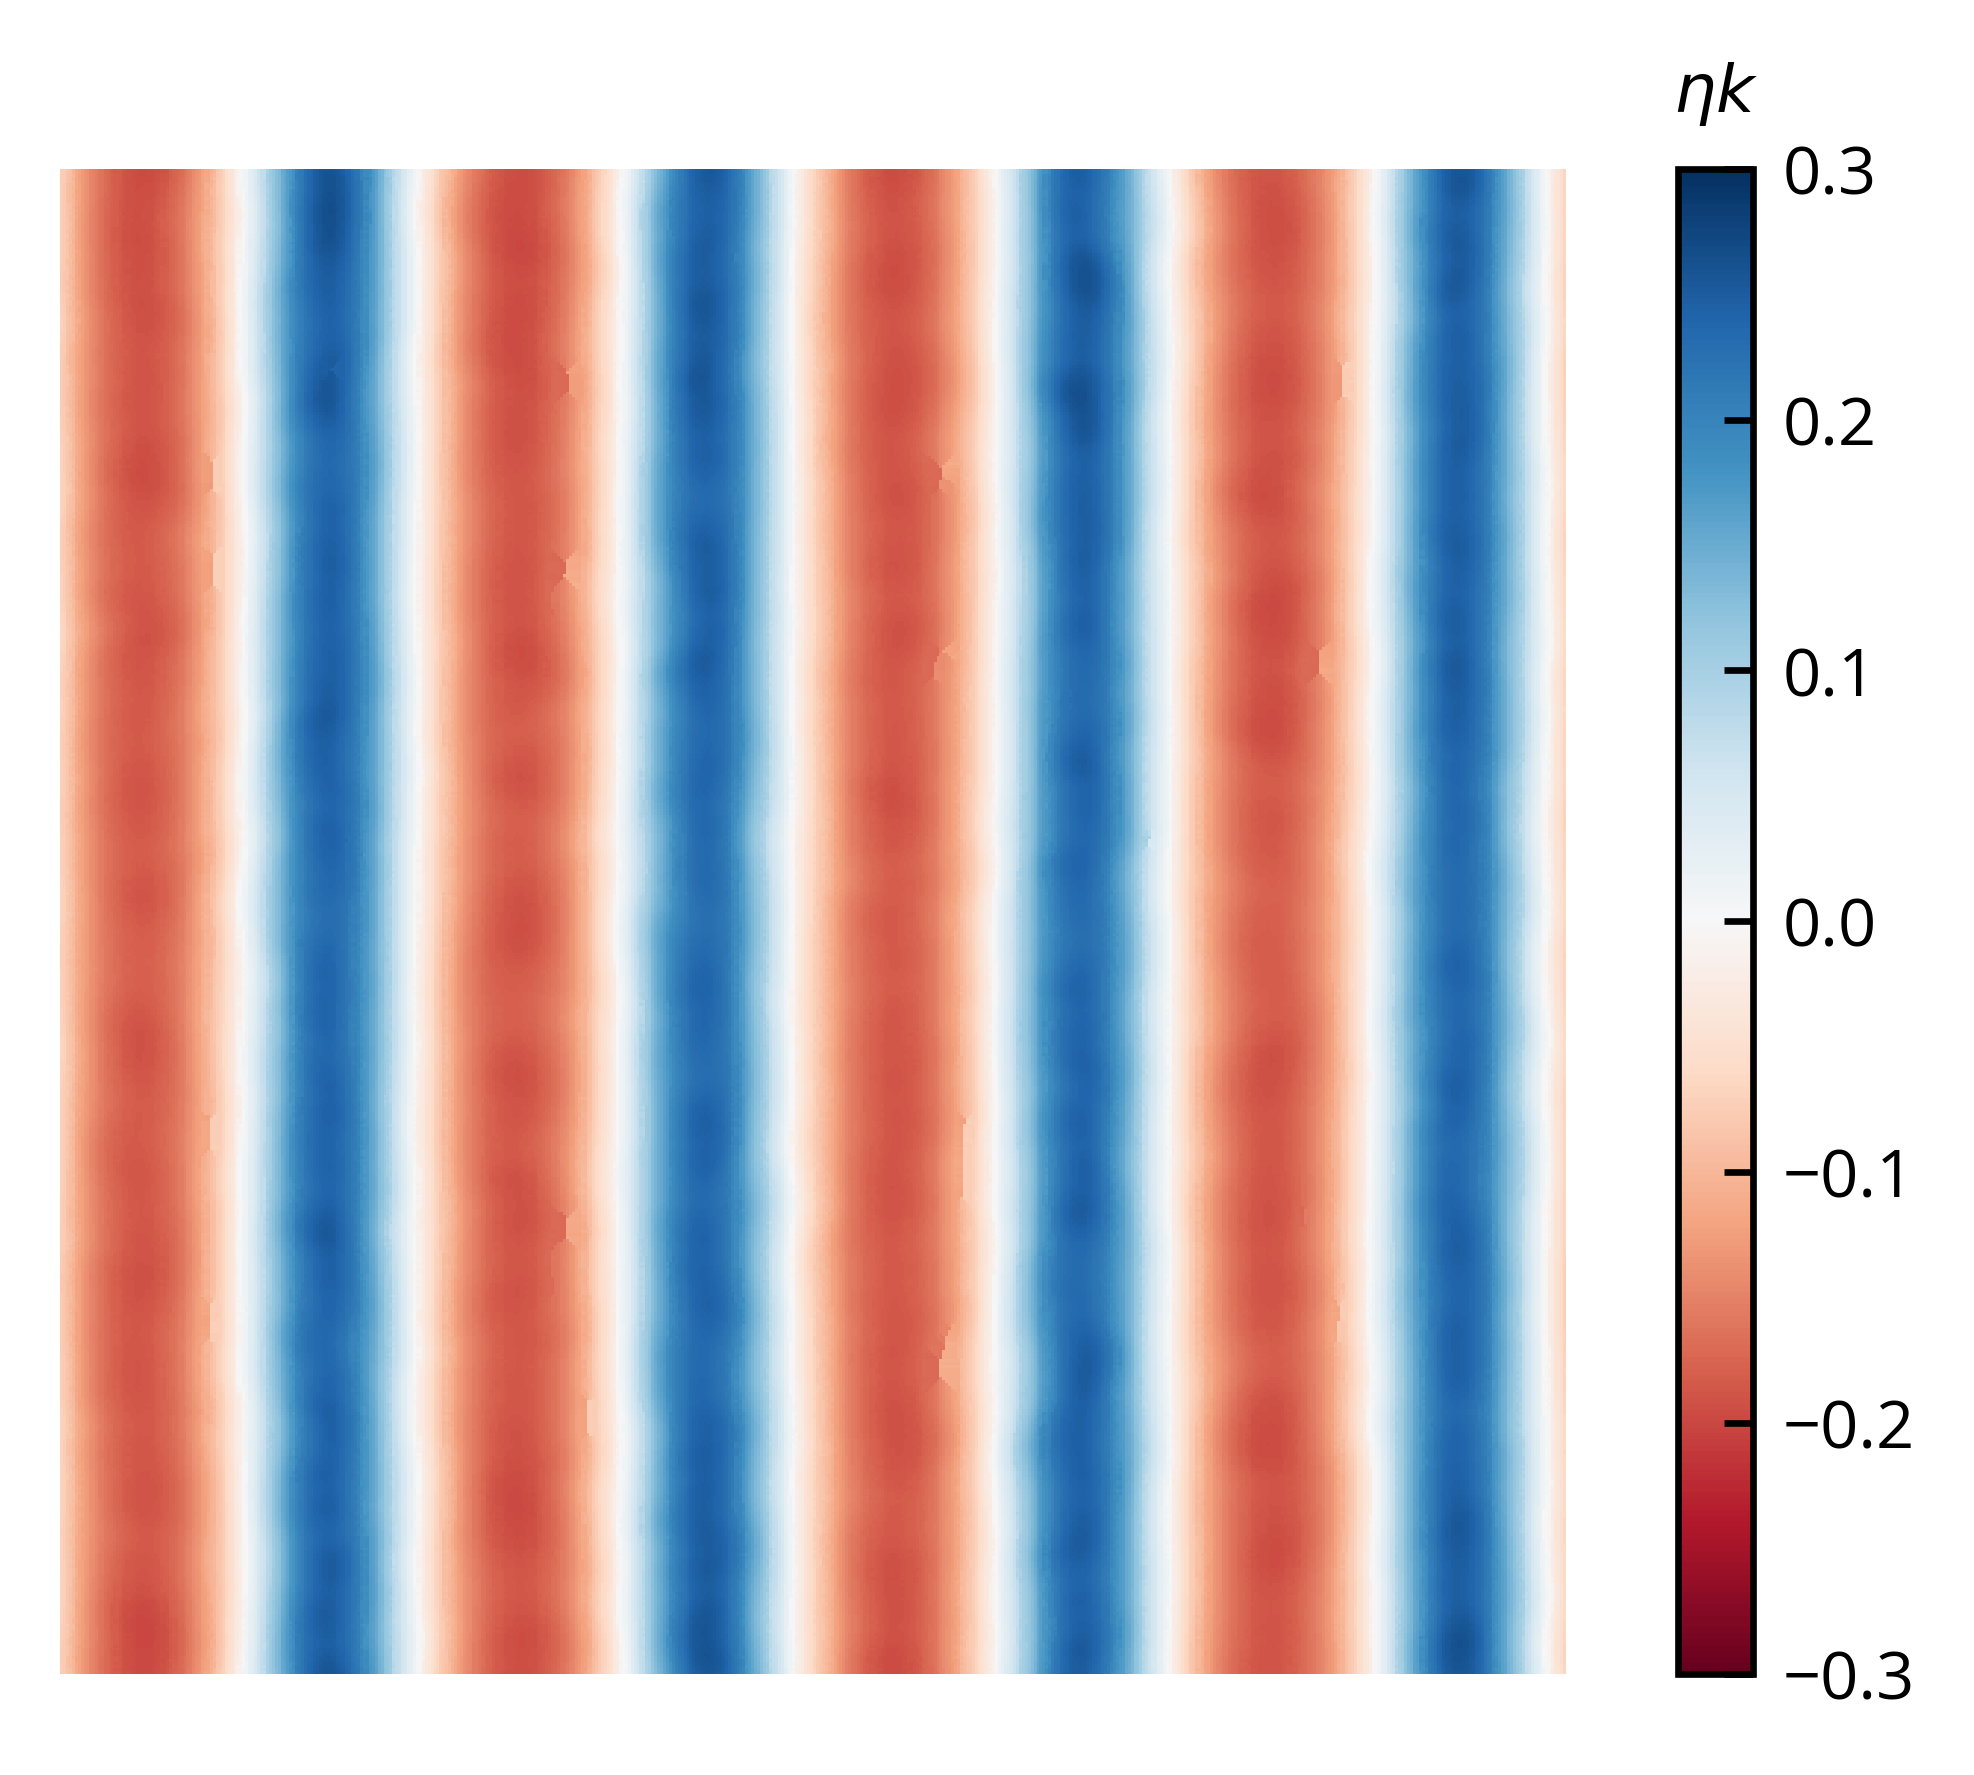

In [64]:
plt.figure(figsize=[4,3])
plt.imshow((interface.eta_tile-np.average(interface.eta_tile))*4, cmap='RdBu', vmax = 0.3, vmin = -0.3, extent = [-L0/2,L0/2,-L0/2,L0/2])
cbar = plt.colorbar(); plt.axis('off')
ax = plt.gca()
ax.text(1.1,1.05, r'$\eta k$', ha='center', va='center', transform=ax.transAxes)

In [ ]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv[0][0:-1])*5/(rho_a*0.25**2), label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

In [80]:
'''
Interpolate the surface pressure from the field output.
This is a serialized version of the function.
'''

from scipy.signal import hilbert
from scipy.signal import butter,filtfilt
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

# Filter requirements.
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/'

NGRID = 512
rho_a = 0.001225
nu_a = 0.25*(2*np.pi-1)/720
NSLICE = 256

t = 84
''' 
Reading in pressure and immediately average over z (quasi 2D assumption).
Should change to fully 3D later. 
'''
pair = {'name':'pair', 'value':[]}
f = {'name':'f', 'value':[]}
field = pair # Later can add more field 
for sn in range(0,NSLICE-1):
    filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
field['value'] = np.average(np.array(field['value']), axis=0)

# To-do: unify the name!
field = f
for sn in range(0,NSLICE-1):
    filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
field['value'] = np.average(np.array(field['value']), axis=0)

''' Read in eta and immediately average over z'''
L0 = 2*np.pi
PRUNING = True
filename = working_dir + 'eta/eta_t%g' % t
snapshot = pd.read_table(filename, delimiter = ',')
if PRUNING:
    snapshot = snapshot[snapshot.x != 'x']
    snapshot = snapshot.astype('float')
    snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
# Interpolate over x-z plane with the same resolutions
# xarray = np.linspace(-L0/2.,L0/2,NGRID)
# zarray = np.linspace(-L0/2.,L0/2,NGRID)
'''
TODO: Figure out why these two are so different!
'''
xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
x_tile, z_tile = np.meshgrid(xarray,zarray)
eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                         (x_tile, z_tile), method='nearest')
eta_1D = np.average(eta_tile, axis=0)

''' Compute 1D eta gradient '''
eta_1D_filtered = butter_lowpass_filter(eta_1D)
eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
# eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
# eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

''' Remove the constant and interpolate p '''
parray = pair['value']
farray = f['value']
pbase = np.average(parray[parray!=0])
print(pbase)
pshift = (parray-pbase)*(1-farray)
ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
# Removing the too high point 
# that are very close to eta and might mess with the interp
pshift[pshift/0.25**2 > 0.5] = 0
# Add some distance
# Test 6 different vertical padded values
pinterp = np.zeros([6, eta_1D_grad.shape[0]])
for ix in range(0, NGRID-1):
    pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        pinterp[NADD-1,ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)

''' Compute interpolated shear stress '''    
ux = {'name':'ux', 'value':[]}
uy = {'name':'uy', 'value':[]}
# TODO uy gradient
for field in (ux, uy): # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
tauv_dudy = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dvdy = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dudx = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dvdx = np.zeros([6, eta_1D_grad.shape[0]])
# Interpolate and then compute the gradient in y 
for ix in range(0, NGRID-1):
    uxgrid = interp1d(ygrid, ux['value'][ix,:], fill_value='extrapolate', kind='quadratic')
    uygrid = interp1d(ygrid, uy['value'][ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        ux_interp1 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        ux_interp2 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
        tauv_dudy[NADD-1,ix] = (ux_interp2-ux_interp1)/(L0/NGRID)
        uy_interp1 = uygrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        uy_interp2 = uygrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
        tauv_dvdy[NADD-1,ix] = (uy_interp2-uy_interp1)/(L0/NGRID)
# Compute the gradient in x first then interpolater
uxgrad = np.gradient(ux['value'], edge_order = 2, axis = 0)/(L0/NGRID)
uygrad = np.gradient(uy['value'], edge_order = 2, axis = 0)/(L0/NGRID)
for ix in range(0, NGRID-1):
    uxgrad_grid = interp1d(ygrid, uxgrad[ix,:], fill_value='extrapolate', kind='quadratic')
    uygrad_grid = interp1d(ygrid, uygrad[ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        tauv_dudx[NADD-1,ix] = uxgrad_grid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        tauv_dvdx[NADD-1,ix] = uygrad_grid(eta_1D_filtered[ix] + L0/NGRID*NADD)

''' Compute the integrated force '''
# p force 6 values to deal with uncertainty
pforce = np.zeros(6)
for NADD in range(1,7):
    ''' TODO: determine is from 1 to -2 is the way to go '''
    pforce[NADD-1] = np.sum(pinterp[NADD-1,:]*eta_1D_grad_filtered[:])/NGRID
print (pforce/(rho_a*0.25**2))

# Compute tangential stress
# tang = np.sum(tauv[1,:]*1/(1+eta_1D_grad_filtered[:]**2)**0.5)/NGRID
# print(tang/(rho_a*0.25**2))
# pforce = np.sum(pinterp[3,:]*1/(1+(1/eta_1D_grad_filtered[:])**2)**0.5)/NGRID
# pforce = np.sum(pinterp[4,:]*eta_1D_grad_filtered[:])/NGRID
# print(pforce/(rho_a*0.25**2))

0.04738301571065997
[0.49984773 0.44717    0.4436001  0.42717181 0.41542405 0.40219744]


In [81]:
tang = np.sum(tauv_dudy[0,:])/NGRID*nu_a
print(tang/(0.25**2))

0.5612908908237532


In [ ]:
''' Additional visualization '''
ETA = False
P2D = False
P1D = True

# For 1D eta
if ETA == True:
    plt.figure(figsize=[4,1.5])
    plt.plot(xarray, eta_1D-1, label=r'$\eta(x)$')
    plt.plot(xarray, eta_1D_filtered-1, label=r'$\eta(x)$ smoothed')
    plt.plot(xarray, eta_1D_grad, label=r'$d\eta/dx$')
    plt.plot(xarray, eta_1D_grad_filtered, label=r'$d\eta/dx$ smoothed')
    plt.ylabel(r'$\eta$')
    plt.legend()

# For 2D p after adjusting constant
if P2D == True:
    fig = plt.figure(figsize=[3,4])
    img = plt.imshow((np.rot90((pshift)*(1-farray))/(rho_a*0.25**2)), cmap='RdBu', vmax = 10, vmin = -10, extent = [-L0/2,L0/2,0,L0])
    plt.axis('off')
    cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
#     cbar.ax.text(0, 30, r'$p/\rho_{a}u_*^2$', ha='center', va='center')
    # Demo the eta choice
    plt.plot(xarray, eta_1D_filtered, lw=0.5, c='k')
    NADD = 2
    plt.plot(xarray, eta_1D_filtered+L0/NGRID*NADD, '--', lw=0.5, c='k')

# For 1D interpolated p
if P1D == True:
    plt.figure(figsize=[4,2])
    for (i,p) in enumerate(pinterp):
        plt.plot(xarray, p/(rho_a*0.25**2), label='%g grid pts above' %(i+1))
    # plt.plot(xgrid, pinterp2/0.25**2, label='%g grid pts above' %NADD2)
    plt.ylim([-40,40])
    plt.xlabel('x'); plt.ylabel(r'$p/\rho_{a}u_*^2$')
    plt.legend()

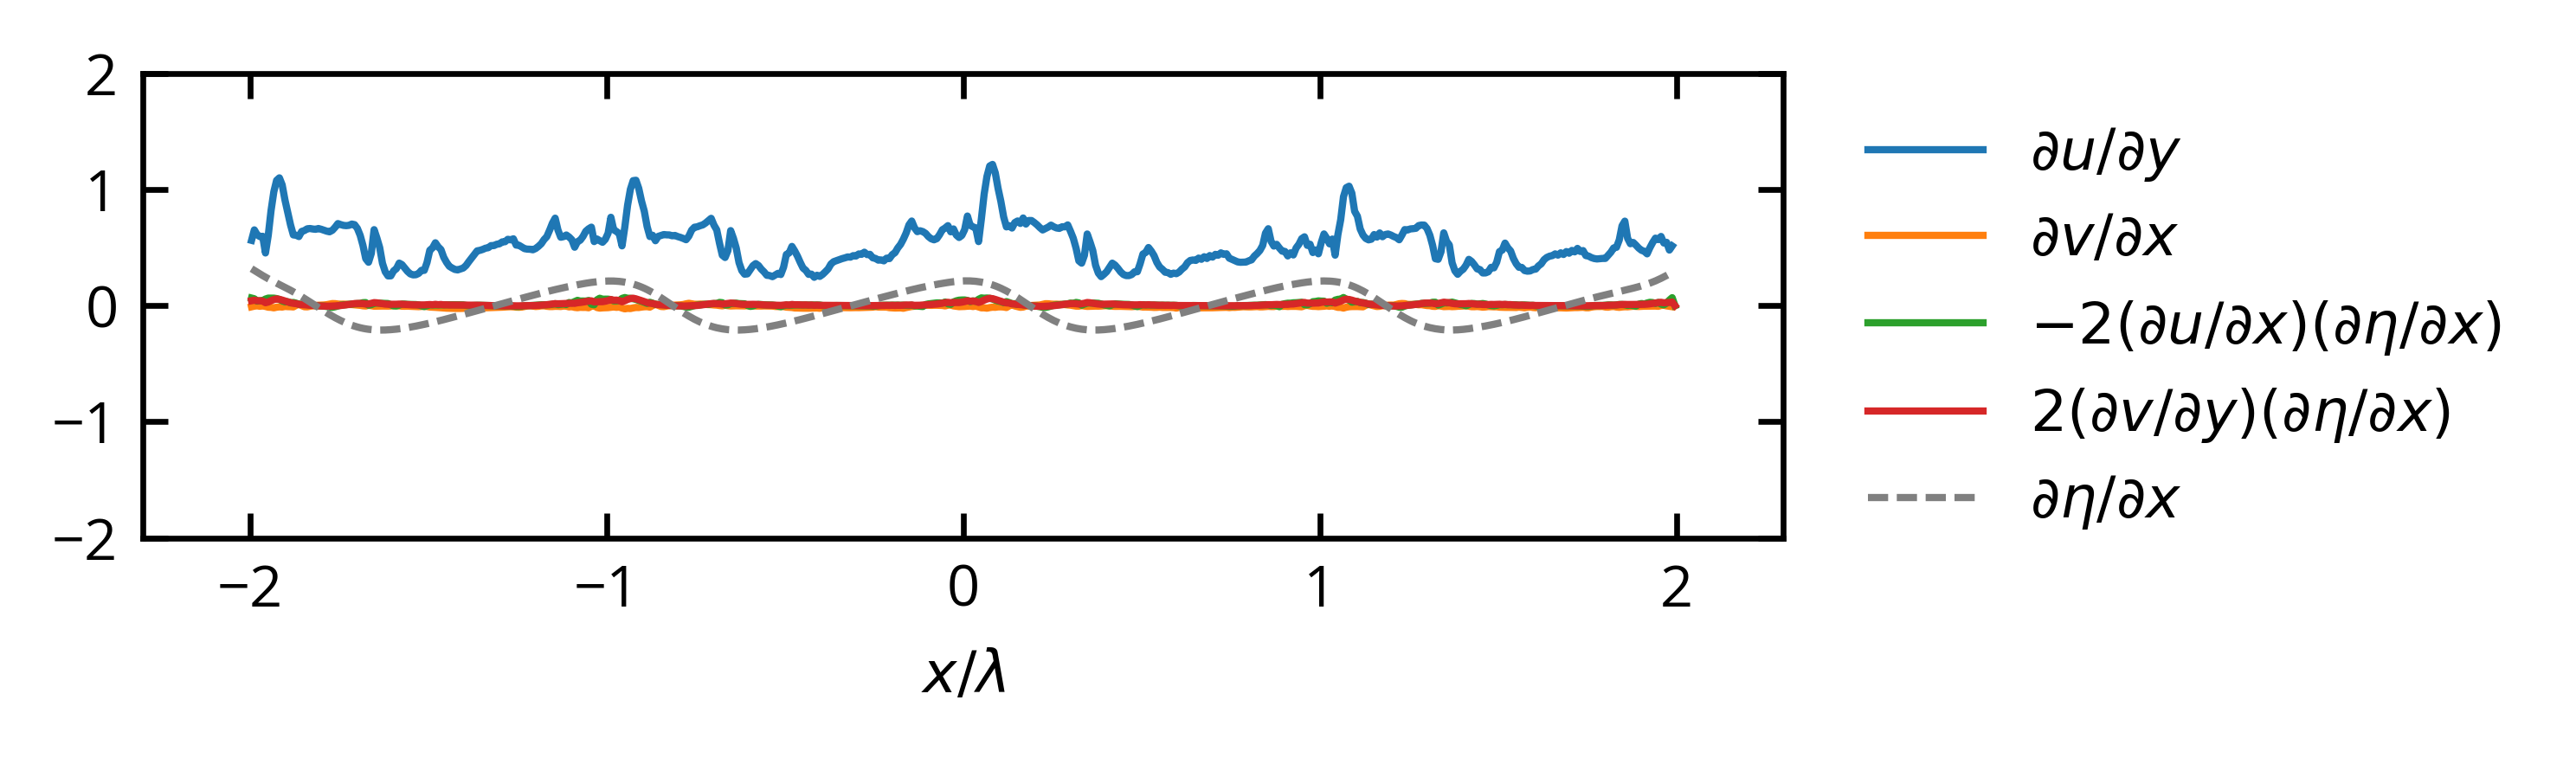

In [46]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dudy[1][0:-1])*nu_a/(0.25**2), 
         label = r'$ \partial u / \partial y $', lw = 1)
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dvdx[1][0:-1])*nu_a/(0.25**2), 
         label = r'$ \partial v / \partial x $', lw = 1)
plt.plot(xarray/(2*np.pi/4), (-2*tauv_dudx[1])*nu_a/(0.25**2)*eta_1D_grad_filtered, 
         label = r'$ -2 (\partial u / \partial x) (\partial \eta/\partial x)$', lw = 1)
plt.plot(xarray/(2*np.pi/4), (2*tauv_dvdy[1])*nu_a/(0.25**2)*eta_1D_grad_filtered, 
         label = r'$ 2 (\partial v / \partial y) (\partial \eta/\partial x)$', lw = 1)
# plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4, label=r'$\eta(x)k $', color = 'gray', lw = 1)
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered, '--', label=r'$\partial \eta/\partial x$ ', color = 'gray', lw = 1)
plt.xlabel(r'$x/\lambda$')
plt.ylim([-2,2])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

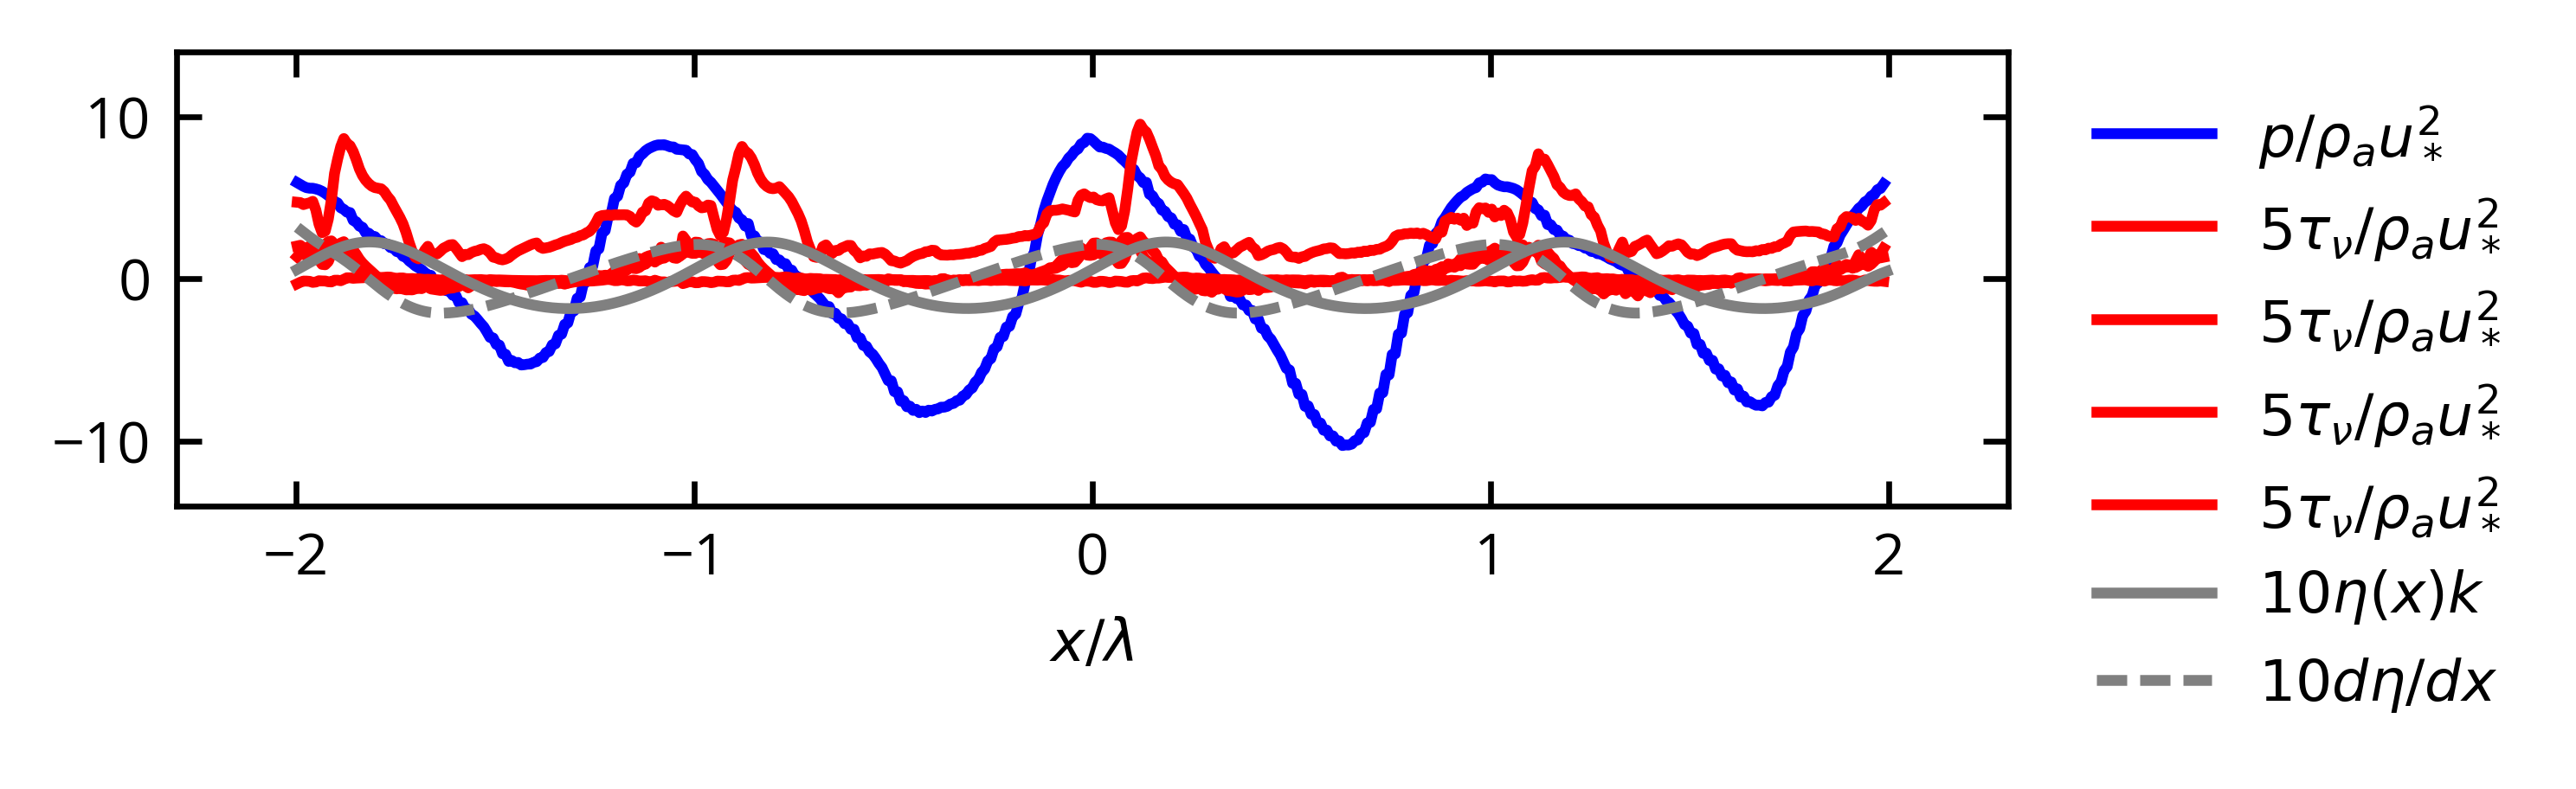

In [29]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[4][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dudy[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dvdx[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (-2*tauv_dudx[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (2*tauv_dvdy[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

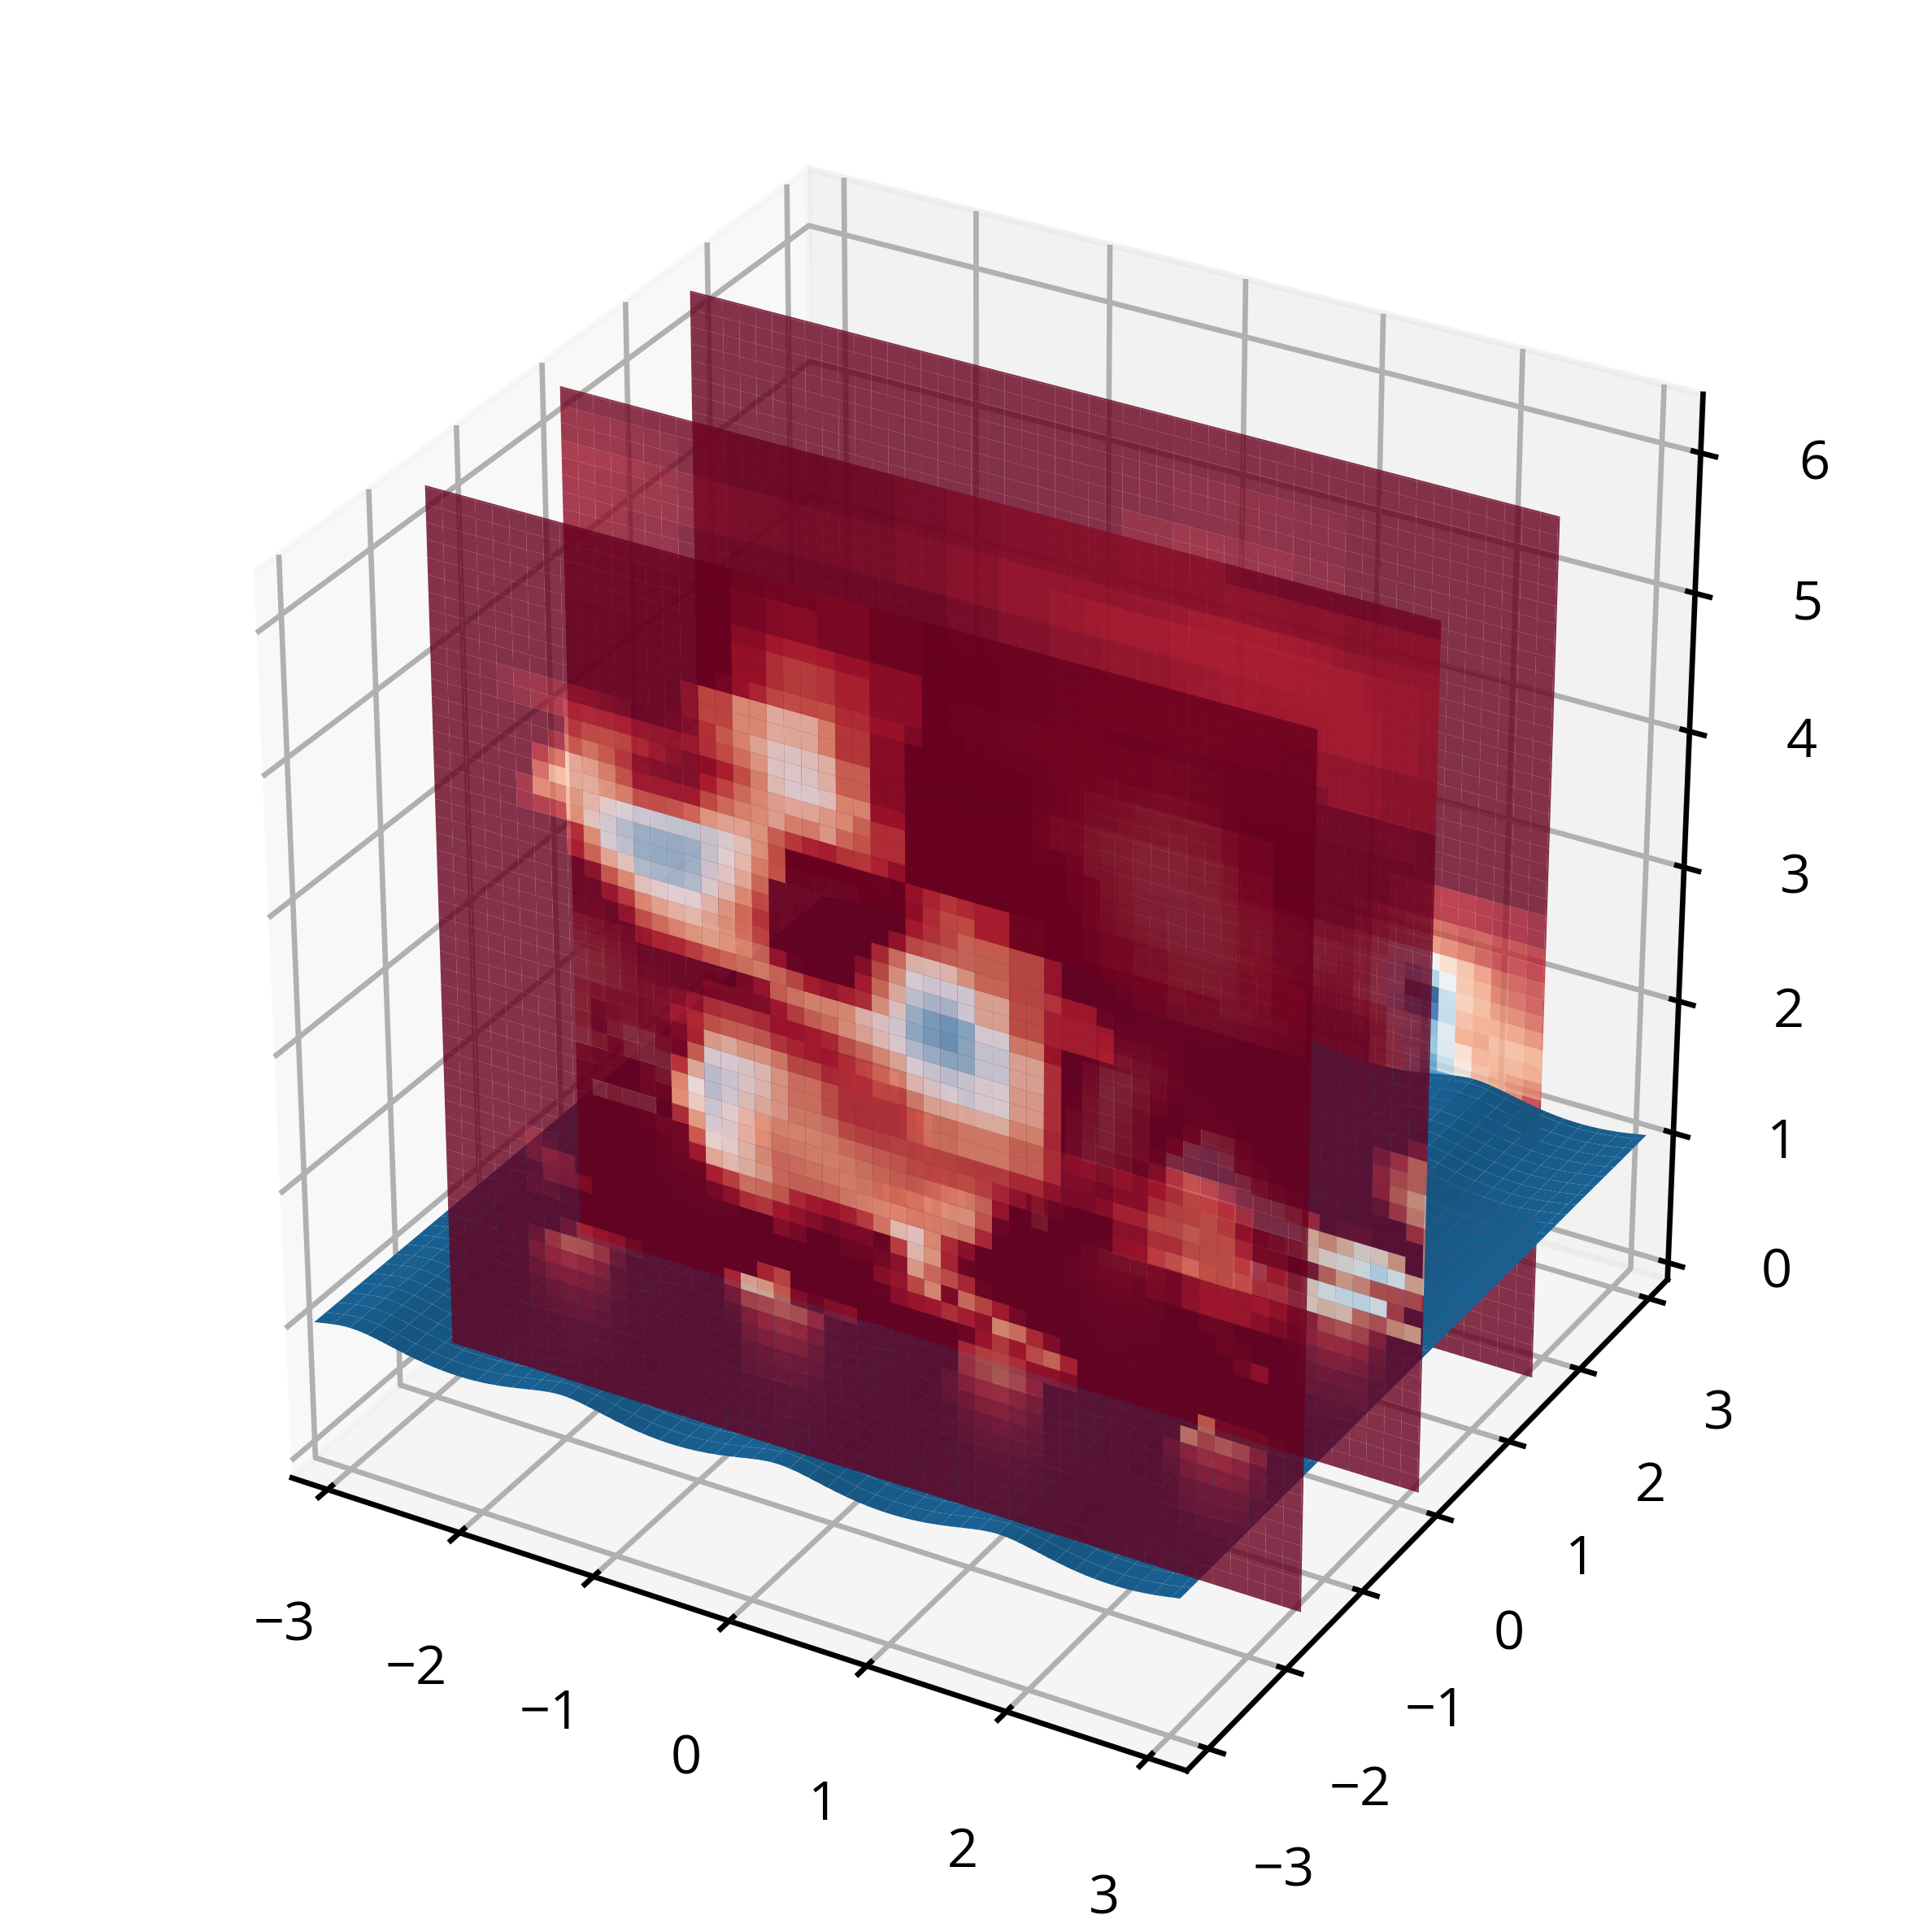

In [48]:
'''
Demonstrating the data processing process. Reference: 
https://stackoverflow.com/questions/25287861/creating-intersecting-images-in-matplotlib-with-imshow-or-other-function/25295272#25295272
https://stackoverflow.com/questions/30464117/plotting-a-imshow-image-in-3d-in-matplotlib
https://matplotlib.org/2.2.2/mpl_toolkits/mplot3d/faq.html
'''
from mpl_toolkits.mplot3d import Axes3D

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')

# create a 512*512 vertex mesh
xx, zz = np.meshgrid(np.linspace(-np.pi,np.pi,512), np.linspace(0.,2*np.pi,512))
# create vertices for a rotated mesh (3D rotation matrix)
X = xx 
Z = zz
# Take a few slices
t = 68
for sn in range(64,256,64):
    Y = (-np.pi + 2.*np.pi/256*sn)*np.ones([512,512])
    filename = working_dir + 'field/'+'uy'+'_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    data = snapshot.reshape([NGRID,NGRID+1])
    data = np.rot90(data[:,0:-1].astype(np.float), 3)
    # show the 3D rotated projection
    ax.plot_surface(X, Y, Z, rstride=10, cstride=10, facecolors=plt.cm.RdBu(data), 
                    alpha = 0.8, linewidth=0, shade=False)

xx, yy = np.meshgrid(np.linspace(-np.pi,np.pi,512), np.linspace(-np.pi,np.pi,512))
ax.plot_surface(xx, yy, interface.eta_tile)
ax.set_xlim([-np.pi, np.pi]); ax.set_ylim([-np.pi, np.pi]); ax.set_zlim([0., 2.*np.pi])
plt.show()

TypeError: entry_points() missing 1 required positional argument: 'name'

In [ ]:
from scipy.signal import hilbert

from scipy.signal import butter,filtfilt
# Filter requirements.
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

class Snapshot:
    '''
    Class for every snapchat
    self.availt: The longest running time
    self.path: Path of the case file
    
    '''  
    def __init__(self, t, working_dir, NSLICE=256, NGRID=256, L0=np.pi*2, trans=False):
        '''
        trans: if phase shift is needed
        self.eta_raw: raw x,z,eta data
        self.eta_tile,self.x_tile,self.z_tile: interpolated eta,x,z with resolution specified by NGRID
        self.eta_1D: eta averaged over z direction
        '''
        self.t = t
        # Declare the fields (do not store as class attribution because of memory issues)
        ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        uy_3D = {'name':'uy', 'value':[]}
        # Read in the fields
        for field in (ux_3D,uy_3D):
            for sn in range (0,NSLICE-1):
                filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (self.t,sn)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                field['value'].append(snapshot[:,0:NGRID].astype(np.float))
            field['value'] = np.array(field['value'])
        # Read in eta
        filename = working_dir + 'eta/eta_t%g' % self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        self.eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos),
                       'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
        # Interpolate over x-z plane with the same resolutions
        xarray = np.linspace(-L0/2,L0/2,NGRID); zarray = np.linspace(-L0/2,L0/2,NGRID)
        self.x_tile, self.z_tile = np.meshgrid(xarray,zarray)
        self.eta_tile = griddata((self.eta_raw['x'].ravel(), self.eta_raw['z'].ravel()), self.eta_raw['eta'].ravel(), 
                                 (self.x_tile, self.z_tile), method='nearest')
        # !To-dos: test for non quasi 1D cases
        self.eta_1D = np.average(self.eta_tile, axis=0)
        # Compute the Reynolds stress
#         self.ux_1D = np.average(ux_3D['value'], axis=(0,1))
#         self.uy_1D = np.average(uy_3D['value'], axis=(0,1))
#         ux_1D_broadcast = np.tile(self.ux_1D, (NSLICE-1, NGRID, 1))
#         uy_1D_broadcast = np.tile(self.uy_1D, (NSLICE-1, NGRID, 1))
#         re_stress_3D = (ux_3D['value']-ux_1D_broadcast)*(uy_3D['value']-uy_1D_broadcast)
#         # Include only z direction averaged 2D profile
#         self.ux_2D = np.average(ux_3D['value'], axis=0)
#         self.uy_2D = np.average(uy_3D['value'], axis=0)
#         self.re_stress_2D = np.average(re_stress_3D,axis=0)             
        # Hilbert transform, performed along x        
        # Filter the data (subtract the mean)
        if trans == True:
            self.eta_1D_filtered = butter_lowpass_filter(self.eta_1D-np.average(self.eta_1D))
            analytic_signal = hilbert(self.eta_1D_filtered)
            self.phase = np.angle(analytic_signal)
            # Shift the velocity field along x axis so that phase starts at 0
            self.idx = (np.abs(self.phase - 0)).argmin()
            self.eta_1D_shift = np.roll(self.eta_1D, -self.idx)
#             self.ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
#             self.uy_3D_shift = {'name':'uy_shift', 'value':[]}
#             for (field,field_shift) in zip((self.ux_3D,self.uy_3D),(self.ux_3D_shift,self.uy_3D_shift)):
#                 field_shift['value'] = np.roll(field['value'], -self.idx, axis=1)

In [ ]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# snapshot_ensemble_360_moving_MU32 = []
for i in tqdm(range(0,1)):
    t = 76 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)

In [ ]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# snapshot_ensemble_360_moving_MU32 = []
for i in tqdm(range(0,1)):
    t = 57 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)

In [ ]:
from scipy.interpolate import interp1d
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/'
# t = 59

def pressure(t, PRUNING = True):
    '''
    This is a function that compute the integrated form drag at time t
    '''
    
    NGRID = 512
    rho_a = 0.001225
    nu_a = 0.25*(2*np.pi-1)/720
    ''' 
    Reading in pressure and immediately average over z (quasi 2D assumption).
    Should change to fully 3D later. 
    '''
    pair = {'name':'pair', 'value':[]}
    f = {'name':'f', 'value':[]}
    field = pair # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
    # To-do: unify the name!
    field = f
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    ''' Read in eta and immediately average over z'''
    L0 = 2*np.pi
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    if PRUNING:
        snapshot = snapshot[snapshot.x != 'x']
        snapshot = snapshot.astype('float')
        snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos), 'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
    # Interpolate over x-z plane with the same resolutions
#     xarray = np.linspace(-L0/2.,L0/2,NGRID)
#     zarray = np.linspace(-L0/2.,L0/2,NGRID)
    '''
    TODO: Figure out why these two are so different!
    '''
    xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)

    ''' Comupte 1D eta gradient '''
    eta_1D_filtered = butter_lowpass_filter(eta_1D)
    eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
    # eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    # eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

    ''' Remove the constant and interpolate p '''
    parray = pair['value']
    farray = f['value']
    pbase = np.average(parray[parray!=0])
    pshift = (parray-pbase)*(1-farray)
    ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
    # Removing the too high point 
    # that are very close to eta and might mess with the interp
    pshift[pshift/0.25**2 > 0.01] = 0
    # Add some distance
    NADD1 = 1
    pinterp1 = np.zeros(eta_1D_grad.shape[0])
    for ix in range(0, NGRID-1):
        pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
        pinterp1[ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD1)
    # NADD2 = 2
    # pinterp2 = np.zeros(eta_1D_grad.shape[0])
    # for ix in range(0, NGRID-1):
    #     pgrid = interp1d(zgrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
    #     pinterp2[ix] = pgrid(eta_1D_filtered[ix]+L0/NGRID*NADD2)

    ''' Compute the integrated force '''
    pforce1 = np.sum(pinterp1*eta_1D_grad_filtered)/NGRID
#     print ('t = %g, pforce = %g' %(t, pforce1/(rho_a*0.25**2)))
    return pforce1

print(pressure(60)/(rho_a*0.25**2))

In [ ]:
t_ensemble = [60,63,66,69]
pforce = np.zeros(4)
for i in tqdm(range(0,4)):
    pforce[i] = pressure(t_ensemble[i])
    print(pforce[i]/(rho_a*0.25**2))

In [ ]:
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/'
print(pressure(59, PRUNING=False)/(rho_a*0.25**2))

In [ ]:
0.25*(2*np.pi-1)/720*0.001225

In [ ]:
'''
This is a serialized version of the function
'''
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'

NGRID = 512
rho_a = 0.001225
nu_a = 0.25*(2*np.pi-1)/720
pforce_ensem = []

for t in tqdm(range(78,79,3)):
    ''' 
    Reading in pressure and immediately average over z (quasi 2D assumption).
    Should change to fully 3D later. 
    '''
    pair = {'name':'pair', 'value':[]}
    f = {'name':'f', 'value':[]}
    field = pair # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    # To-do: unify the name!
    field = f
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    ''' Read in eta and immediately average over z'''
    L0 = 2*np.pi
    PRUNING = True
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    if PRUNING:
        snapshot = snapshot[snapshot.x != 'x']
        snapshot = snapshot.astype('float')
        snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos), 'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
    # Interpolate over x-z plane with the same resolutions
    # xarray = np.linspace(-L0/2.,L0/2,NGRID)
    # zarray = np.linspace(-L0/2.,L0/2,NGRID)
    '''
    TODO: Figure out why these two are so different!
    '''
    xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)

    ''' Comupte 1D eta gradient '''
    eta_1D_filtered = butter_lowpass_filter(eta_1D)
    eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
    # eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    # eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

    ''' Remove the constant and interpolate p '''
    parray = pair['value']
    farray = f['value']
    pbase = np.average(parray[parray!=0])
    print(pbase)
    pshift = (parray-pbase)*(1-farray)
    ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
    # Removing the too high point 
    # that are very close to eta and might mess with the interp
    pshift[pshift/0.25**2 > 0.5] = 0
    # Add some distance
    # Test 6 different vertical padded values
    pinterp = np.zeros([6, eta_1D_grad.shape[0]])
    for ix in range(0, NGRID-1):
        pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
        for NADD in range(1,7):
            pinterp[NADD-1,ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
    
    ''' Compute interpolated shear stress '''    
    ux = {'name':'ux', 'value':[]}
    # TODO uy gradient
    field = ux # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
    tauv = np.zeros([6, eta_1D_grad.shape[0]])
    for ix in range(0, NGRID-1):
        uxgrid = interp1d(ygrid, ux['value'][ix,:], fill_value='extrapolate', kind='quadratic')
        for NADD in range(1,7):
            ux_interp1 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
            ux_interp2 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
            tauv[NADD-1,ix] = (ux_interp2-ux_interp1)/(L0/NGRID)*nu_a*rho_a

    ''' Compute the integrated force '''
    pforce = np.zeros(6)
    for NADD in range(1,7):
        ''' TODO: determine is from 1 to -2 is the way to go '''
        pforce[NADD-1] = np.sum(pinterp[NADD-1,:]*eta_1D_grad_filtered[:])/NGRID
    print (pforce/(rho_a*0.25**2))
    pforce_ensem.append(pforce[3])

# print (pforce_ensem/(rho_a*0.25**2))

In [ ]:
tang = np.sum(tauv[1,:]*1/(1+eta_1D_grad_filtered[:]**2)**0.5)/NGRID
print(tang/(rho_a*0.25**2))
# pforce = np.sum(pinterp[3,:]*1/(1+(1/eta_1D_grad_filtered[:])**2)**0.5)/NGRID
pforce = np.sum(pinterp[4,:]*eta_1D_grad_filtered[:])/NGRID
print(pforce/(rho_a*0.25**2))

In [ ]:
xarray = np.linspace(-L0/2.,L0/2,NGRID)
yarray = np.linspace(0,L0,NGRID)
y_tile, x_tile = np.meshgrid(yarray,xarray)

In [ ]:
''' Additional visualization '''
ETA = False
P2D = False
P1D = True

# For 1D eta
if ETA == True:
    plt.figure(figsize=[4,1.5])
    plt.plot(xarray, eta_1D-1, label=r'$\eta(x)$')
    plt.plot(xarray, eta_1D_filtered-1, label=r'$\eta(x)$ smoothed')
    plt.plot(xarray, eta_1D_grad, label=r'$d\eta/dx$')
    plt.plot(xarray, eta_1D_grad_filtered, label=r'$d\eta/dx$ smoothed')
    plt.ylabel(r'$\eta$')
    plt.legend()

# For 2D p after adjusting constant
if P2D == True:
    fig = plt.figure(figsize=[3,4])
    img = plt.imshow((np.rot90((pshift)*(1-farray))/(rho_a*0.25**2)), cmap='RdBu', vmax = 10, vmin = -10, extent = [-L0/2,L0/2,0,L0])
    plt.axis('off')
    cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
#     cbar.ax.text(0, 30, r'$p/\rho_{a}u_*^2$', ha='center', va='center')
    # Demo the eta choice
    plt.plot(xarray, eta_1D_filtered, lw=0.5, c='k')
    NADD = 2
    plt.plot(xarray, eta_1D_filtered+L0/NGRID*NADD, '--', lw=0.5, c='k')

# For 1D interpolated p
if P1D == True:
    plt.figure(figsize=[4,2])
    for (i,p) in enumerate(pinterp):
        plt.plot(xarray, p/(rho_a*0.25**2), label='%g grid pts above' %(i+1))
    # plt.plot(xgrid, pinterp2/0.25**2, label='%g grid pts above' %NADD2)
    plt.ylim([-40,40])
    plt.xlabel('x'); plt.ylabel(r'$p/\rho_{a}u_*^2$')
    plt.legend()

In [ ]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv[1][0:-1])*5/(rho_a*0.25**2), label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

In [ ]:
pforce1 = np.zeros(6); pforce2 = np.zeros(6); pforce3 = np.zeros(6)
for NADD in range(1,7):
    ''' TODO: determine is from 1 to -2 is the way to go '''
    pforce1[NADD-1] = np.sum(pinterp[NADD-1,1:-2]*eta_1D_grad_filtered[1:-2])/NGRID
    pforce2[NADD-1] = np.sum(pinterp[NADD-1,0:-1]*eta_1D_grad_filtered[0:-1])/NGRID
    pforce3[NADD-1] = np.sum((pinterp[NADD-1,:])*eta_1D_grad_filtered[:])/NGRID

In [ ]:
plt.plot(pforce1/(rho_a*0.25**2),'.')
plt.plot(pforce2/(rho_a*0.25**2),'.')
plt.plot(pforce3/(rho_a*0.25**2),'.')

In [ ]:
np.sum(eta_1D_grad_filtered[:-2])

In [ ]:
eta_1D_grad_filtered[-1]